***Mamba Block***

In [1]:
# PlantXMamba/mamba_block/pscan.py
import math

import torch
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from tqdm import tqdm


def npo2(len):
    """
    Returns the next power of 2 above len
    """

    return 2 ** math.ceil(math.log2(len))


def pad_npo2(X):
    """
    Pads input length dim to the next power of 2

    Args:
        X : (B, L, D, N)

    Returns:
        Y : (B, npo2(L), D, N)
    """

    len_npo2 = npo2(X.size(1))
    pad_tuple = (0, 0, 0, 0, 0, len_npo2 - X.size(1))
    return F.pad(X, pad_tuple, "constant", 0)


class PScan(torch.autograd.Function):
    @staticmethod
    def pscan(A, X):
        # A : (B, D, L, N)
        # X : (B, D, L, N)

        # modifies X in place by doing a parallel scan.
        # more formally, X will be populated by these values :
        # H[t] = A[t] * H[t-1] + X[t] with H[0] = 0
        # which are computed in parallel (2*log2(T) sequential steps (ideally), instead of T sequential steps)

        # only supports L that is a power of two (mainly for a clearer code)

        B, D, L, _ = A.size()
        num_steps = int(math.log2(L))

        # up sweep (last 2 steps unfolded)
        Aa = A
        Xa = X
        for _ in range(num_steps - 2):
            T = Xa.size(2)
            Aa = Aa.view(B, D, T // 2, 2, -1)
            Xa = Xa.view(B, D, T // 2, 2, -1)

            Xa[:, :, :, 1].add_(Aa[:, :, :, 1].mul(Xa[:, :, :, 0]))
            Aa[:, :, :, 1].mul_(Aa[:, :, :, 0])

            Aa = Aa[:, :, :, 1]
            Xa = Xa[:, :, :, 1]

        # we have only 4, 2 or 1 nodes left
        if Xa.size(2) == 4:
            Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 0]))
            Aa[:, :, 1].mul_(Aa[:, :, 0])

            Xa[:, :, 3].add_(
                Aa[:, :, 3].mul(Xa[:, :, 2] + Aa[:, :, 2].mul(Xa[:, :, 1]))
            )
        elif Xa.size(2) == 2:
            Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 0]))
            return
        else:
            return

        # down sweep (first 2 steps unfolded)
        Aa = A[:, :, 2 ** (num_steps - 2) - 1 : L : 2 ** (num_steps - 2)]
        Xa = X[:, :, 2 ** (num_steps - 2) - 1 : L : 2 ** (num_steps - 2)]
        Xa[:, :, 2].add_(Aa[:, :, 2].mul(Xa[:, :, 1]))
        Aa[:, :, 2].mul_(Aa[:, :, 1])

        for k in range(num_steps - 3, -1, -1):
            Aa = A[:, :, 2**k - 1 : L : 2**k]
            Xa = X[:, :, 2**k - 1 : L : 2**k]

            T = Xa.size(2)
            Aa = Aa.view(B, D, T // 2, 2, -1)
            Xa = Xa.view(B, D, T // 2, 2, -1)

            Xa[:, :, 1:, 0].add_(Aa[:, :, 1:, 0].mul(Xa[:, :, :-1, 1]))
            Aa[:, :, 1:, 0].mul_(Aa[:, :, :-1, 1])

    @staticmethod
    def pscan_rev(A, X):
        # A : (B, D, L, N)
        # X : (B, D, L, N)

        # the same function as above, but in reverse
        # (if you flip the input, call pscan, then flip the output, you get what this function outputs)
        # it is used in the backward pass

        # only supports L that is a power of two (mainly for a clearer code)

        B, D, L, _ = A.size()
        num_steps = int(math.log2(L))

        # up sweep (last 2 steps unfolded)
        Aa = A
        Xa = X
        for _ in range(num_steps - 2):
            T = Xa.size(2)
            Aa = Aa.view(B, D, T // 2, 2, -1)
            Xa = Xa.view(B, D, T // 2, 2, -1)

            Xa[:, :, :, 0].add_(Aa[:, :, :, 0].mul(Xa[:, :, :, 1]))
            Aa[:, :, :, 0].mul_(Aa[:, :, :, 1])

            Aa = Aa[:, :, :, 0]
            Xa = Xa[:, :, :, 0]

        # we have only 4, 2 or 1 nodes left
        if Xa.size(2) == 4:
            Xa[:, :, 2].add_(Aa[:, :, 2].mul(Xa[:, :, 3]))
            Aa[:, :, 2].mul_(Aa[:, :, 3])

            Xa[:, :, 0].add_(
                Aa[:, :, 0].mul(Xa[:, :, 1].add(Aa[:, :, 1].mul(Xa[:, :, 2])))
            )
        elif Xa.size(2) == 2:
            Xa[:, :, 0].add_(Aa[:, :, 0].mul(Xa[:, :, 1]))
            return
        else:
            return

        # down sweep (first 2 steps unfolded)
        Aa = A[:, :, 0 : L : 2 ** (num_steps - 2)]
        Xa = X[:, :, 0 : L : 2 ** (num_steps - 2)]
        Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 2]))
        Aa[:, :, 1].mul_(Aa[:, :, 2])

        for k in range(num_steps - 3, -1, -1):
            Aa = A[:, :, 0 : L : 2**k]
            Xa = X[:, :, 0 : L : 2**k]

            T = Xa.size(2)
            Aa = Aa.view(B, D, T // 2, 2, -1)
            Xa = Xa.view(B, D, T // 2, 2, -1)

            Xa[:, :, :-1, 1].add_(Aa[:, :, :-1, 1].mul(Xa[:, :, 1:, 0]))
            Aa[:, :, :-1, 1].mul_(Aa[:, :, 1:, 0])

    @staticmethod
    def forward(ctx, A_in, X_in):
        """
        Applies the parallel scan operation, as defined above. Returns a new tensor.
        If you can, privilege sequence lengths that are powers of two.

        Args:
            A_in : (B, L, D, N)
            X_in : (B, L, D, N)

        Returns:
            H : (B, L, D, N)
        """

        L = X_in.size(1)

        # cloning is requiered because of the in-place ops
        if L == npo2(L):
            A = A_in.clone()
            X = X_in.clone()
        else:
            # pad tensors (and clone btw)
            A = pad_npo2(A_in)  # (B, npo2(L), D, N)
            X = pad_npo2(X_in)  # (B, npo2(L), D, N)

        # prepare tensors
        A = A.transpose(2, 1)  # (B, D, npo2(L), N)
        X = X.transpose(2, 1)  # (B, D, npo2(L), N)

        # parallel scan (modifies X in-place)
        PScan.pscan(A, X)

        ctx.save_for_backward(A_in, X)

        # slice [:, :L] (cut if there was padding)
        return X.transpose(2, 1)[:, :L]

    @staticmethod
    def backward(ctx, grad_output_in):
        """
        Flows the gradient from the output to the input. Returns two new tensors.

        Args:
            ctx : A_in : (B, L, D, N), X : (B, D, L, N)
            grad_output_in : (B, L, D, N)

        Returns:
            gradA : (B, L, D, N), gradX : (B, L, D, N)
        """

        A_in, X = ctx.saved_tensors

        L = grad_output_in.size(1)

        # cloning is requiered because of the in-place ops
        if L == npo2(L):
            grad_output = grad_output_in.clone()
            # the next padding will clone A_in
        else:
            grad_output = pad_npo2(grad_output_in)  # (B, npo2(L), D, N)
            A_in = pad_npo2(A_in)  # (B, npo2(L), D, N)

        # prepare tensors
        grad_output = grad_output.transpose(2, 1)
        A_in = A_in.transpose(2, 1)  # (B, D, npo2(L), N)
        A = torch.nn.functional.pad(
            A_in[:, :, 1:], (0, 0, 0, 1)
        )  # (B, D, npo2(L), N) shift 1 to the left (see hand derivation)

        # reverse parallel scan (modifies grad_output in-place)
        PScan.pscan_rev(A, grad_output)

        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_output[:, :, 1:])

        return Q.transpose(2, 1)[:, :L], grad_output.transpose(2, 1)[:, :L]


pscan = PScan.apply

In [2]:
# PlantXMamba/mamba_block/backbone.py
import math
from dataclasses import dataclass
from typing import Union


"""

This file closely follows the mamba_simple.py from the official Mamba implementation, and the mamba-minimal by @johnma2006.
The major differences are :
-the convolution is done with torch.nn.Conv1d
-the selective scan is done in PyTorch

A sequential version of the selective scan is also available for comparison. Also, it is possible to use the official Mamba implementation.

This is the structure of the torch modules :
- A Mamba model is composed of several layers, which are ResidualBlock.
- A ResidualBlock is composed of a MambaBlock, a normalization, and a residual connection : ResidualBlock(x) = mamba(norm(x)) + x
- This leaves us with the MambaBlock : its input x is (B, L, D) and its outputs y is also (B, L, D) (B=batch size, L=seq len, D=model dim).
First, we expand x into (B, L, 2*ED) (where E is usually 2) and split it into x and z, each (B, L, ED).
Then, we apply the short 1d conv to x, followed by an activation function (silu), then the SSM.
We then multiply it by silu(z).
See Figure 3 of the paper (page 8) for a visual representation of a MambaBlock.

"""


@dataclass
class MambaConfig:
    d_model: int  # D
    n_layers: int
    dt_rank: Union[int, str] = "auto"
    d_state: int = 16  # N in paper/comments
    expand_factor: int = 2  # E in paper/comments
    d_conv: int = 4

    dt_min: float = 0.001
    dt_max: float = 0.1
    dt_init: str = "random"  # "random" or "constant"
    dt_scale: float = 1.0
    dt_init_floor = 1e-4

    rms_norm_eps: float = 1e-5
    base_std: float = 0.02

    dropout: float = 0.1

    bias: bool = False
    conv_bias: bool = True
    inner_layernorms: bool = False  # apply layernorms to internal activations

    mup: bool = False
    mup_base_width: float = 128  # width=d_model

    pscan: bool = True  # use parallel scan mode or sequential mode when training
    use_cuda: bool = False  # use official CUDA implementation when training (not compatible with (b)float16)

    def __post_init__(self):
        self.d_inner = self.expand_factor * self.d_model  # E*D = ED in comments

        if self.dt_rank == "auto":
            self.dt_rank = math.ceil(self.d_model / 16)

        # muP
        if self.mup:
            self.mup_width_mult = self.d_model / self.mup_base_width


class Mamba(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.config = config

        self.layers = nn.ModuleList(
            [ResidualBlock(config) for _ in range(config.n_layers)]
        )

    def forward(self, x):
        # x : (B, L, D)

        # y : (B, L, D)

        for layer in self.layers:
            x = layer(x)

        return x

    def step(self, x, caches):
        # x : (B, L, D)
        # caches : [cache(layer) for all layers], cache : (h, inputs)

        # y : (B, L, D)
        # caches : [cache(layer) for all layers], cache : (h, inputs)

        for i, layer in enumerate(self.layers):
            x, caches[i] = layer.step(x, caches[i])

        return x, caches


class ResidualBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.mixer = MambaBlock(config)
        self.norm = RMSNorm(config.d_model, config.rms_norm_eps, config.mup)

    def forward(self, x):
        # x : (B, L, D)

        # output : (B, L, D)

        output = self.mixer(self.norm(x)) + x
        return output

    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
        # h : (B, ED, N)
        # inputs: (B, ED, d_conv-1)

        # output : (B, D)
        # cache : (h, inputs)

        output, cache = self.mixer.step(self.norm(x), cache)
        output = output + x
        return output, cache


class MambaBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.config = config

        # projects block input from D to 2*ED (two branches)
        self.in_proj = nn.Linear(config.d_model, 2 * config.d_inner, bias=config.bias)

        self.conv1d = nn.Conv1d(
            in_channels=config.d_inner,
            out_channels=config.d_inner,
            kernel_size=config.d_conv,
            bias=config.conv_bias,
            groups=config.d_inner,
            padding=config.d_conv - 1,
        )

        # projects x to input-dependent delta, B, C
        self.x_proj = nn.Linear(
            config.d_inner, config.dt_rank + 2 * config.d_state, bias=False
        )

        # projects delta from dt_rank to d_inner
        self.dt_proj = nn.Linear(config.dt_rank, config.d_inner, bias=True)

        # dt initialization
        # dt weights
        dt_init_std = config.dt_rank**-0.5 * config.dt_scale
        if config.dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif config.dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError

        # delta bias
        dt = torch.exp(
            torch.rand(config.d_inner)
            * (math.log(config.dt_max) - math.log(config.dt_min))
            + math.log(config.dt_min)
        ).clamp(min=config.dt_init_floor)
        inv_dt = dt + torch.log(
            -torch.expm1(-dt)
        )  # inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        # self.dt_proj.bias._no_reinit = True # initialization would set all Linear.bias to zero, need to mark this one as _no_reinit
        # todo : explain why removed

        # S4D real initialization
        A = torch.arange(1, config.d_state + 1, dtype=torch.float32).repeat(
            config.d_inner, 1
        )
        self.A_log = nn.Parameter(
            torch.log(A)
        )  # why store A in log ? to keep A < 0 (cf -torch.exp(...)) ? for gradient stability ?
        self.A_log._no_weight_decay = True

        self.D = nn.Parameter(torch.ones(config.d_inner))
        self.D._no_weight_decay = True

        # projects block output from ED back to D
        self.out_proj = nn.Linear(config.d_inner, config.d_model, bias=config.bias)

        # used in jamba
        if self.config.inner_layernorms:
            self.dt_layernorm = RMSNorm(
                self.config.dt_rank, config.rms_norm_eps, config.mup
            )
            self.B_layernorm = RMSNorm(
                self.config.d_state, config.rms_norm_eps, config.mup
            )
            self.C_layernorm = RMSNorm(
                self.config.d_state, config.rms_norm_eps, config.mup
            )
        else:
            self.dt_layernorm = None
            self.B_layernorm = None
            self.C_layernorm = None

        if self.config.use_cuda:
            try:
                from mamba_ssm.ops.selective_scan_interface import selective_scan_fn

                self.selective_scan_cuda = selective_scan_fn
            except ImportError:
                print("Failed to import mamba_ssm. Falling back to mamba.py.")
                self.config.use_cuda = False

    def _apply_layernorms(self, dt, B, C):
        if self.dt_layernorm is not None:
            dt = self.dt_layernorm(dt)
        if self.B_layernorm is not None:
            B = self.B_layernorm(B)
        if self.C_layernorm is not None:
            C = self.C_layernorm(C)
        return dt, B, C

    def forward(self, x):
        # x : (B, L, D)

        # y : (B, L, D)

        _, L, _ = x.shape

        xz = self.in_proj(x)  # (B, L, 2*ED)
        x, z = xz.chunk(2, dim=-1)  # (B, L, ED), (B, L, ED)

        # x branch
        x = x.transpose(1, 2)  # (B, ED, L)
        x = self.conv1d(x)[
            :, :, :L
        ]  # depthwise convolution over time, with a short filter
        x = x.transpose(1, 2)  # (B, L, ED)

        x = F.silu(x)
        y = self.ssm(x, z)

        if self.config.use_cuda:
            output = self.out_proj(y)  # (B, L, D)
            return output  # the rest of the operations are done in the ssm function (fused with the CUDA pscan)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output)  # (B, L, D)

        return output

    def ssm(self, x, z):
        # x : (B, L, ED)

        # y : (B, L, ED)

        A = -torch.exp(self.A_log.float())  # (ED, N)
        D = self.D.float()

        deltaBC = self.x_proj(x)  # (B, L, dt_rank+2*N)
        delta, B, C = torch.split(
            deltaBC,
            [self.config.dt_rank, self.config.d_state, self.config.d_state],
            dim=-1,
        )  # (B, L, dt_rank), (B, L, N), (B, L, N)
        delta, B, C = self._apply_layernorms(delta, B, C)
        delta = self.dt_proj.weight @ delta.transpose(
            1, 2
        )  # (ED, dt_rank) @ (B, L, dt_rank) -> (B, ED, L)

        if self.config.use_cuda:
            # these are unfortunately needed for the selective_scan_cuda function
            x = x.transpose(1, 2)
            B = B.transpose(1, 2)
            C = C.transpose(1, 2)
            z = z.transpose(1, 2)

            # "softplus" + "bias" + "y * silu(z)" operations are fused
            y = self.selective_scan_cuda(
                x,
                delta,
                A,
                B,
                C,
                D,
                z=z,
                delta_softplus=True,
                delta_bias=self.dt_proj.bias.float(),
            )
            y = y.transpose(1, 2)  # (B, L, ED)

        else:
            delta = delta.transpose(1, 2)
            delta = F.softplus(delta + self.dt_proj.bias)

            if self.config.pscan:
                y = self.selective_scan(x, delta, A, B, C, D)
            else:
                y = self.selective_scan_seq(x, delta, A, B, C, D)

        return y

    def selective_scan(self, x, delta, A, B, C, D):
        deltaA = torch.exp(delta.unsqueeze(-1) * A)  # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2)  # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1))  # (B, L, ED, N)

        hs = pscan(deltaA, BX)

        y = (hs @ C.unsqueeze(-1)).squeeze(
            3
        )  # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y

    def selective_scan_seq(self, x, delta, A, B, C, D):

        _, L, _ = x.shape

        deltaA = torch.exp(delta.unsqueeze(-1) * A)  # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2)  # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1))  # (B, L, ED, N)

        h = torch.zeros(
            x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device
        )  # (B, ED, N)
        hs = []

        for t in range(0, L):
            h = deltaA[:, t] * h + BX[:, t]
            hs.append(h)

        hs = torch.stack(hs, dim=1)  # (B, L, ED, N)

        y = (hs @ C.unsqueeze(-1)).squeeze(
            3
        )  # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y

    # -------------------------- inference -------------------------- #
    """
    Concerning auto-regressive inference

    The cool part of using Mamba : inference is constant wrt to sequence length
    We just have to keep in cache, for each layer, two things :
    - the hidden state h (which is (B, ED, N)), as you typically would when doing inference with a RNN
    - the last d_conv-1 inputs of the layer, to be able to compute the 1D conv which is a convolution over the time dimension
      (d_conv is fixed so this doesn't incur a growing cache as we progress on generating the sequence)
      (and d_conv is usually very small, like 4, so we just have to "remember" the last 3 inputs)

    Concretely, these two quantities are put inside a cache tuple, and are named h and inputs respectively.
    h is (B, ED, N), and inputs is (B, ED, d_conv-1)
    The MambaBlock.step() receives this cache, and, along with outputing the output, alos outputs the updated cache for the next call.

    The cache object is initialized as follows : (None, torch.zeros()).
    When h is None, the selective scan function detects it and start with h=0.
    The torch.zeros() isn't a problem (it's same as just feeding the input, because the conv1d is padded)

    As we need one such cache variable per layer, we store a caches object, which is simply a list of cache object. (See mamba_lm.py)
    """

    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
        # h : (B, ED, N)
        # inputs : (B, ED, d_conv-1)

        # y : (B, D)
        # cache : (h, inputs)

        h, inputs = cache

        xz = self.in_proj(x)  # (B, 2*ED)
        x, z = xz.chunk(2, dim=1)  # (B, ED), (B, ED)

        # x branch
        x_cache = x.unsqueeze(2)
        x = self.conv1d(torch.cat([inputs, x_cache], dim=2))[
            :, :, self.config.d_conv - 1
        ]  # (B, ED)

        x = F.silu(x)
        y, h = self.ssm_step(x, h)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output)  # (B, D)

        # prepare cache for next call
        inputs = torch.cat([inputs[:, :, 1:], x_cache], dim=2)  # (B, ED, d_conv-1)
        cache = (h, inputs)

        return output, cache

    def ssm_step(self, x, h):
        # x : (B, ED)
        # h : (B, ED, N)

        # y : (B, ED)
        # h : (B, ED, N)

        A = -torch.exp(
            self.A_log.float()
        )  # (ED, N) # todo : ne pas le faire tout le temps, puisque c'est indépendant de la timestep
        D = self.D.float()

        deltaBC = self.x_proj(x)  # (B, dt_rank+2*N)

        delta, B, C = torch.split(
            deltaBC,
            [self.config.dt_rank, self.config.d_state, self.config.d_state],
            dim=-1,
        )  # (B, dt_rank), (B, N), (B, N)
        delta, B, C = self._apply_layernorms(delta, B, C)
        delta = F.softplus(self.dt_proj(delta))  # (B, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A)  # (B, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(1)  # (B, ED, N)

        BX = deltaB * (x.unsqueeze(-1))  # (B, ED, N)

        if h is None:
            h = torch.zeros(
                x.size(0),
                self.config.d_inner,
                self.config.d_state,
                device=deltaA.device,
            )  # (B, ED, N)

        h = deltaA * h + BX  # (B, ED, N)

        y = (h @ C.unsqueeze(-1)).squeeze(2)  # (B, ED, N) @ (B, N, 1) -> (B, ED, 1)

        y = y + D * x

        return y, h


class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5, use_mup: bool = False):
        super().__init__()

        self.use_mup = use_mup
        self.eps = eps

        # https://arxiv.org/abs/2404.05728, RMSNorm gains prevents muTransfer (section 4.2.3)
        if not use_mup:
            self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

        if not self.use_mup:
            return output * self.weight
        else:
            return output


In [3]:
# PlantXMamba/mamba_block/head.py
import torch
import torch.nn as nn
import torch.nn.functional as F


class MambaHead(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.norm(x)
        x = self.dropout(x)
        return x  # (batch_size, seq_len, d_model)

In [4]:
# PlantXMamba/mamba_block/model.py
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

class MambaModule(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.d_model = self.args.d_model
        self.n_layers = self.args.n_layers

        config = MambaConfig(d_model=self.d_model, n_layers=self.n_layers,
                           d_state=self.args.d_state, d_conv=self.args.d_conv,
                           expand_factor=self.args.expand,dropout=self.args.dropout)
        self.backbone = Mamba(config)
        self.head = MambaHead(d_model=self.d_model, dropout=self.args.dropout)

    def forward(self, x):
        sequence_output = self.backbone(x)  # (batch_size, seq_len, d_model)
        output = self.head(sequence_output)  # (batch_size, seq_len, d_model)
        return output

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG16_Weights

In [55]:
from torchvision.models import inception_v3, Inception_V3_Weights

class InceptionBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        inception = inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)
        inception.aux_logits = False  # Disable aux

        # Lấy feature extractor từ inception
        self.features = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(3, stride=2),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(3, stride=2),
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
        )
        # Output feature map shape: (B, 2048, 8, 8)

    def forward(self, x):
        return self.features(x)


In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size=5, emb_size=16):
        super().__init__()
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.proj = nn.Linear(in_channels * patch_size * patch_size, emb_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(B, -1, C * self.patch_size * self.patch_size)
        return self.proj(x)  # shape: (b,num patches,emb size)

In [56]:
class PlantXMamba(nn.Module):
    def __init__(self, num_classes=4, patch_size=5, emb_size=16, d_state=64,d_conv=64,expand=4,n_layers=2,num_blocks=4, dropout=0.1):
        super().__init__()

        # VGG16 (2 blocks)
        # vgg = models.vgg16(weights=VGG16_Weights.DEFAULT)
        # self.vgg_block = nn.Sequential(*list(vgg.features[:10]))

        # Inception-like block → (B, 512, 56, 56)
        # self.inception = InceptionBlock(in_channels=128)
        self.inception = InceptionBackbone() #Only inception

        # Patch Embedding → (B, 121, 16)
        # self.patch_embed = PatchEmbedding(in_channels=512, patch_size=patch_size, emb_size=emb_size) 
        # self.patch_embed = PatchEmbedding(in_channels=128, patch_size=patch_size, emb_size=emb_size) #Only VGG
        self.patch_embed = PatchEmbedding(in_channels=2048, patch_size=patch_size, emb_size=emb_size) #Only Inception
        
        # Mamba blocks
        mamba_args = type('Args', (), {
            'd_model': emb_size,
            'd_state': d_state,
            'd_conv': d_conv,
            'expand': expand,
            'n_layers': n_layers,
            'dropout': dropout
        })()
        self.mamba = nn.Sequential(*[MambaModule(mamba_args) for _ in range(num_blocks)])

        # Classification head
        self.norm = nn.LayerNorm(emb_size)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        # x = self.vgg_block(x)  # (B, 128, 56, 56)
        x = self.inception(x)  # (B, 512, 56, 56)
        x = self.patch_embed(x)  # (B, 121, 16)
        x = self.mamba(x)  # (B, 121, 16)
        x = self.norm(x)  # (B, 121, 16)
        x = x.permute(0, 2, 1)  # (B, 16, 121)
        x = self.global_pool(x).squeeze(-1)  # (B, 16)
        return self.classifier(x)  # (B, num_classes)


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlantXMamba(num_classes=4).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 80.3MB/s] 


***Data***

In [19]:
!git clone https://github.com/sakanaowo/PlantXViT

Cloning into 'PlantXViT'...
remote: Enumerating objects: 104825, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 104825 (delta 6), reused 20 (delta 4), pack-reused 104802 (from 1)
Receiving objects: 100% (104825/104825), 2.45 GiB | 44.81 MiB/s, done.
Resolving deltas: 100% (30447/30447), done.
Updating files: 100% (104353/104353), done.


In [21]:
from PlantXViT.utils.config_loader import load_config
config=load_config('PlantXViT/configs/config.yaml')
     

import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import pickle
     

csv_path='./PlantXViT/data/raw/plant-pathology-2020-fgvc7/train.csv'
label_encoder_path='./PlantXViT/data/processed/apple_label_encoder.pkl'
print(label_encoder_path)

./PlantXViT/data/processed/apple_label_encoder.pkl


In [22]:
df = pd.read_csv(csv_path)
df['label'] = df[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)

# encode label
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# split train/val
train_df, val_df = train_test_split(df, test_size=0.2,
                                    stratify=df['label'],
                                    random_state=42)

# Encode labels
label_encoder = LabelEncoder()
train_df['label_idx'] = label_encoder.fit_transform(train_df['label'])
val_df['label_idx'] = label_encoder.transform(val_df['label'])

image_dir = "./PlantXViT/data/raw/plant-pathology-2020-fgvc7/images"
train_df = pd.read_csv("./PlantXViT/data/processed/apple/apple_train.csv")
val_df = pd.read_csv("./PlantXViT/data/processed/apple/apple_val.csv")

In [28]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class AppleDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image_id'] + ".jpg")
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = torch.tensor(row['label_idx'])
        return image, label

In [29]:
from torch.utils.data import DataLoader

batch_size = config["training"]["batch_size"]

train_dataset = AppleDataset(train_df, image_dir, train_transform)
val_dataset = AppleDataset(val_df, image_dir, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)

***Train***

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch

def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []

    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc


from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, cohen_kappa_score, accuracy_score
)

def val(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []  # Để tính AUC

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    try:
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except:
        auc = float('nan')

    kappa = cohen_kappa_score(all_labels, all_preds)

    return avg_loss, acc, precision, recall, f1, auc, kappa, all_labels, all_preds


In [59]:
best_f1 = 0.0
save_path = "InceptionMamba_apple_306.pth"
num_epochs = 50

# Lưu toàn bộ metric cho cả train và val
train_metrics = {
    "loss": [], "acc": []
}
val_metrics = {
    "loss": [], "acc": [], "precision": [], "recall": [], "f1": [], "auc": [], "kappa": []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    train_loss, train_acc = train(model, train_loader, optimizer, loss_function, device)

    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, val_kappa, val_labels, val_preds = val(model, val_loader, loss_function, device)

    train_metrics["loss"].append(train_loss)
    train_metrics["acc"].append(train_acc)

    val_metrics["loss"].append(val_loss)
    val_metrics["acc"].append(val_acc)
    val_metrics["precision"].append(val_prec)
    val_metrics["recall"].append(val_rec)
    val_metrics["f1"].append(val_f1)
    val_metrics["auc"].append(val_auc)
    val_metrics["kappa"].append(val_kappa)

    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}, Kappa: {val_kappa:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), save_path)
        print(f"Saved new best model with F1: {best_f1:.4f}")

print("\nTraining complete.")



Epoch 1/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


Train - Loss: 0.8760, Acc: 0.6793
Val   - Loss: 0.4752, Acc: 0.8932, Precision: 0.8523, Recall: 0.8932, F1: 0.8707, AUC: 0.8566, Kappa: 0.8435
Saved new best model with F1: 0.8707

Epoch 2/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.47it/s]


Train - Loss: 0.5328, Acc: 0.8880
Val   - Loss: 0.4046, Acc: 0.8986, Precision: 0.9075, Recall: 0.8986, F1: 0.8795, AUC: 0.9387, Kappa: 0.8516
Saved new best model with F1: 0.8795

Epoch 3/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.29it/s]


Train - Loss: 0.4554, Acc: 0.9148
Val   - Loss: 0.3332, Acc: 0.9397, Precision: 0.9419, Recall: 0.9397, F1: 0.9323, AUC: 0.9488, Kappa: 0.9121
Saved new best model with F1: 0.9323

Epoch 4/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.25it/s]


Train - Loss: 0.3975, Acc: 0.9334
Val   - Loss: 0.3088, Acc: 0.9315, Precision: 0.9291, Recall: 0.9315, F1: 0.9296, AUC: 0.9563, Kappa: 0.9011

Epoch 5/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.44it/s]


Train - Loss: 0.3489, Acc: 0.9457
Val   - Loss: 0.3070, Acc: 0.9205, Precision: 0.9160, Recall: 0.9205, F1: 0.9162, AUC: 0.9672, Kappa: 0.8850

Epoch 6/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.52it/s]


Train - Loss: 0.3094, Acc: 0.9602
Val   - Loss: 0.2878, Acc: 0.9288, Precision: 0.9284, Recall: 0.9288, F1: 0.9257, AUC: 0.9746, Kappa: 0.8970

Epoch 7/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


Train - Loss: 0.2619, Acc: 0.9691
Val   - Loss: 0.3169, Acc: 0.9151, Precision: 0.9117, Recall: 0.9151, F1: 0.9111, AUC: 0.9564, Kappa: 0.8772

Epoch 8/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.39it/s]


Train - Loss: 0.2355, Acc: 0.9705
Val   - Loss: 0.2771, Acc: 0.9370, Precision: 0.9383, Recall: 0.9370, F1: 0.9359, AUC: 0.9715, Kappa: 0.9092
Saved new best model with F1: 0.9359

Epoch 9/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.51it/s]


Train - Loss: 0.2313, Acc: 0.9684
Val   - Loss: 0.2745, Acc: 0.9342, Precision: 0.9341, Recall: 0.9342, F1: 0.9321, AUC: 0.9615, Kappa: 0.9048

Epoch 10/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.11it/s]


Train - Loss: 0.2162, Acc: 0.9670
Val   - Loss: 0.2652, Acc: 0.9315, Precision: 0.9325, Recall: 0.9315, F1: 0.9306, AUC: 0.9600, Kappa: 0.9014

Epoch 11/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.47it/s]


Train - Loss: 0.1688, Acc: 0.9828
Val   - Loss: 0.2501, Acc: 0.9315, Precision: 0.9329, Recall: 0.9315, F1: 0.9317, AUC: 0.9656, Kappa: 0.9015

Epoch 12/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.51it/s]


Train - Loss: 0.1583, Acc: 0.9815
Val   - Loss: 0.2904, Acc: 0.9260, Precision: 0.9247, Recall: 0.9260, F1: 0.9205, AUC: 0.9702, Kappa: 0.8923

Epoch 13/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.52it/s]


Train - Loss: 0.1727, Acc: 0.9698
Val   - Loss: 0.3386, Acc: 0.9068, Precision: 0.9073, Recall: 0.9068, F1: 0.9046, AUC: 0.9568, Kappa: 0.8654

Epoch 14/50


Evaluating: 100%|██████████| 23/23 [00:04<00:00,  4.64it/s]


Train - Loss: 0.1493, Acc: 0.9780
Val   - Loss: 0.2649, Acc: 0.9342, Precision: 0.9369, Recall: 0.9342, F1: 0.9335, AUC: 0.9764, Kappa: 0.9054

Epoch 15/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.51it/s]


Train - Loss: 0.1509, Acc: 0.9739
Val   - Loss: 0.2577, Acc: 0.9233, Precision: 0.9378, Recall: 0.9233, F1: 0.9285, AUC: 0.9755, Kappa: 0.8909

Epoch 16/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]


Train - Loss: 0.1643, Acc: 0.9657
Val   - Loss: 0.2620, Acc: 0.9178, Precision: 0.9170, Recall: 0.9178, F1: 0.9165, AUC: 0.9699, Kappa: 0.8814

Epoch 17/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1307, Acc: 0.9760
Val   - Loss: 0.2395, Acc: 0.9397, Precision: 0.9396, Recall: 0.9397, F1: 0.9396, AUC: 0.9808, Kappa: 0.9132
Saved new best model with F1: 0.9396

Epoch 18/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.51it/s]


Train - Loss: 0.1617, Acc: 0.9602
Val   - Loss: 0.2114, Acc: 0.9370, Precision: 0.9314, Recall: 0.9370, F1: 0.9324, AUC: 0.9731, Kappa: 0.9086

Epoch 19/50


Evaluating: 100%|██████████| 23/23 [00:04<00:00,  4.69it/s]


Train - Loss: 0.1255, Acc: 0.9746
Val   - Loss: 0.3343, Acc: 0.9096, Precision: 0.9171, Recall: 0.9096, F1: 0.9055, AUC: 0.9765, Kappa: 0.8690

Epoch 20/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1458, Acc: 0.9684
Val   - Loss: 0.2296, Acc: 0.9425, Precision: 0.9428, Recall: 0.9425, F1: 0.9426, AUC: 0.9833, Kappa: 0.9172
Saved new best model with F1: 0.9426

Epoch 21/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.52it/s]


Train - Loss: 0.1198, Acc: 0.9773
Val   - Loss: 0.2522, Acc: 0.9342, Precision: 0.9319, Recall: 0.9342, F1: 0.9322, AUC: 0.9651, Kappa: 0.9050

Epoch 22/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.30it/s]


Train - Loss: 0.0843, Acc: 0.9856
Val   - Loss: 0.2760, Acc: 0.9260, Precision: 0.9258, Recall: 0.9260, F1: 0.9244, AUC: 0.9653, Kappa: 0.8932

Epoch 23/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.53it/s]


Train - Loss: 0.1053, Acc: 0.9801
Val   - Loss: 0.2221, Acc: 0.9397, Precision: 0.9385, Recall: 0.9397, F1: 0.9386, AUC: 0.9744, Kappa: 0.9131

Epoch 24/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.43it/s]


Train - Loss: 0.0769, Acc: 0.9876
Val   - Loss: 0.3026, Acc: 0.9178, Precision: 0.9074, Recall: 0.9178, F1: 0.9085, AUC: 0.9673, Kappa: 0.8802

Epoch 25/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.52it/s]


Train - Loss: 0.0809, Acc: 0.9870
Val   - Loss: 0.2975, Acc: 0.9233, Precision: 0.9273, Recall: 0.9233, F1: 0.9210, AUC: 0.9727, Kappa: 0.8891

Epoch 26/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.57it/s]


Train - Loss: 0.0518, Acc: 0.9938
Val   - Loss: 0.3045, Acc: 0.9151, Precision: 0.9189, Recall: 0.9151, F1: 0.9156, AUC: 0.9715, Kappa: 0.8780

Epoch 27/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.56it/s]


Train - Loss: 0.0659, Acc: 0.9890
Val   - Loss: 0.2990, Acc: 0.9315, Precision: 0.9294, Recall: 0.9315, F1: 0.9262, AUC: 0.9508, Kappa: 0.9005

Epoch 28/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.03it/s]


Train - Loss: 0.0675, Acc: 0.9876
Val   - Loss: 0.2841, Acc: 0.9260, Precision: 0.9305, Recall: 0.9260, F1: 0.9271, AUC: 0.9648, Kappa: 0.8939

Epoch 29/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.58it/s]


Train - Loss: 0.0709, Acc: 0.9835
Val   - Loss: 0.2855, Acc: 0.9288, Precision: 0.9265, Recall: 0.9288, F1: 0.9265, AUC: 0.9685, Kappa: 0.8968

Epoch 30/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.55it/s]


Train - Loss: 0.0670, Acc: 0.9883
Val   - Loss: 0.2614, Acc: 0.9452, Precision: 0.9434, Recall: 0.9452, F1: 0.9436, AUC: 0.9561, Kappa: 0.9207
Saved new best model with F1: 0.9436

Epoch 31/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.38it/s]


Train - Loss: 0.0656, Acc: 0.9890
Val   - Loss: 0.2773, Acc: 0.9370, Precision: 0.9345, Recall: 0.9370, F1: 0.9340, AUC: 0.9414, Kappa: 0.9088

Epoch 32/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.48it/s]


Train - Loss: 0.0765, Acc: 0.9856
Val   - Loss: 0.5444, Acc: 0.8767, Precision: 0.8769, Recall: 0.8767, F1: 0.8720, AUC: 0.9348, Kappa: 0.8217

Epoch 33/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.41it/s]


Train - Loss: 0.1021, Acc: 0.9760
Val   - Loss: 0.3175, Acc: 0.9123, Precision: 0.9099, Recall: 0.9123, F1: 0.9101, AUC: 0.9502, Kappa: 0.8735

Epoch 34/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.04it/s]


Train - Loss: 0.0566, Acc: 0.9897
Val   - Loss: 0.3295, Acc: 0.9205, Precision: 0.9253, Recall: 0.9205, F1: 0.9207, AUC: 0.9511, Kappa: 0.8859

Epoch 35/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.47it/s]


Train - Loss: 0.0562, Acc: 0.9890
Val   - Loss: 0.3060, Acc: 0.9315, Precision: 0.9287, Recall: 0.9315, F1: 0.9298, AUC: 0.9576, Kappa: 0.9011

Epoch 36/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.39it/s]


Train - Loss: 0.0416, Acc: 0.9931
Val   - Loss: 0.3231, Acc: 0.9205, Precision: 0.9208, Recall: 0.9205, F1: 0.9204, AUC: 0.9288, Kappa: 0.8857

Epoch 37/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


Train - Loss: 0.0573, Acc: 0.9883
Val   - Loss: 0.2621, Acc: 0.9425, Precision: 0.9436, Recall: 0.9425, F1: 0.9419, AUC: 0.9626, Kappa: 0.9171

Epoch 38/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.34it/s]


Train - Loss: 0.0665, Acc: 0.9863
Val   - Loss: 0.2763, Acc: 0.9397, Precision: 0.9411, Recall: 0.9397, F1: 0.9392, AUC: 0.9594, Kappa: 0.9132

Epoch 39/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.41it/s]


Train - Loss: 0.0640, Acc: 0.9842
Val   - Loss: 0.2812, Acc: 0.9260, Precision: 0.9321, Recall: 0.9260, F1: 0.9283, AUC: 0.9574, Kappa: 0.8941

Epoch 40/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.33it/s]


Train - Loss: 0.0610, Acc: 0.9828
Val   - Loss: 0.1949, Acc: 0.9534, Precision: 0.9543, Recall: 0.9534, F1: 0.9528, AUC: 0.9691, Kappa: 0.9329
Saved new best model with F1: 0.9528

Epoch 41/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.01it/s]


Train - Loss: 0.0432, Acc: 0.9924
Val   - Loss: 0.2177, Acc: 0.9562, Precision: 0.9547, Recall: 0.9562, F1: 0.9546, AUC: 0.9601, Kappa: 0.9367
Saved new best model with F1: 0.9546

Epoch 42/50


Evaluating: 100%|██████████| 23/23 [00:04<00:00,  4.66it/s]


Train - Loss: 0.0465, Acc: 0.9904
Val   - Loss: 0.2462, Acc: 0.9397, Precision: 0.9370, Recall: 0.9397, F1: 0.9378, AUC: 0.9649, Kappa: 0.9130

Epoch 43/50


Evaluating: 100%|██████████| 23/23 [00:04<00:00,  4.66it/s]


Train - Loss: 0.0324, Acc: 0.9959
Val   - Loss: 0.2667, Acc: 0.9370, Precision: 0.9370, Recall: 0.9370, F1: 0.9349, AUC: 0.9577, Kappa: 0.9089

Epoch 44/50


Evaluating: 100%|██████████| 23/23 [00:04<00:00,  4.71it/s]


Train - Loss: 0.0377, Acc: 0.9924
Val   - Loss: 0.2776, Acc: 0.9397, Precision: 0.9380, Recall: 0.9397, F1: 0.9375, AUC: 0.9481, Kappa: 0.9130

Epoch 45/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.43it/s]


Train - Loss: 0.0342, Acc: 0.9945
Val   - Loss: 0.2550, Acc: 0.9479, Precision: 0.9470, Recall: 0.9479, F1: 0.9469, AUC: 0.9541, Kappa: 0.9248

Epoch 46/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.56it/s]


Train - Loss: 0.0416, Acc: 0.9931
Val   - Loss: 0.2136, Acc: 0.9562, Precision: 0.9545, Recall: 0.9562, F1: 0.9549, AUC: 0.9593, Kappa: 0.9367
Saved new best model with F1: 0.9549

Epoch 47/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.04it/s]


Train - Loss: 0.0241, Acc: 0.9959
Val   - Loss: 0.2760, Acc: 0.9425, Precision: 0.9389, Recall: 0.9425, F1: 0.9398, AUC: 0.9502, Kappa: 0.9167

Epoch 48/50


Evaluating: 100%|██████████| 23/23 [00:05<00:00,  4.50it/s]


Train - Loss: 0.0334, Acc: 0.9938
Val   - Loss: 0.2975, Acc: 0.9452, Precision: 0.9445, Recall: 0.9452, F1: 0.9430, AUC: 0.9445, Kappa: 0.9208

Epoch 49/50


Evaluating: 100%|██████████| 23/23 [00:04<00:00,  4.62it/s]


Train - Loss: 0.0577, Acc: 0.9876
Val   - Loss: 0.5896, Acc: 0.8575, Precision: 0.9147, Recall: 0.8575, F1: 0.8771, AUC: 0.9336, Kappa: 0.8014

Epoch 50/50


Evaluating: 100%|██████████| 23/23 [00:04<00:00,  4.63it/s]

Train - Loss: 0.0319, Acc: 0.9945
Val   - Loss: 0.2951, Acc: 0.9452, Precision: 0.9415, Recall: 0.9452, F1: 0.9415, AUC: 0.9516, Kappa: 0.9207

Training complete.


***Plot & Confusion Matrix***

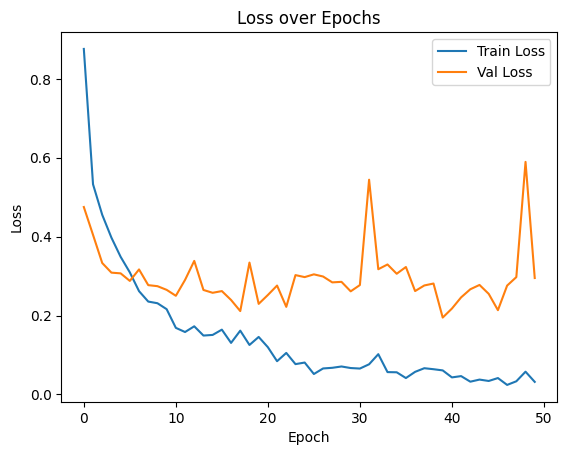

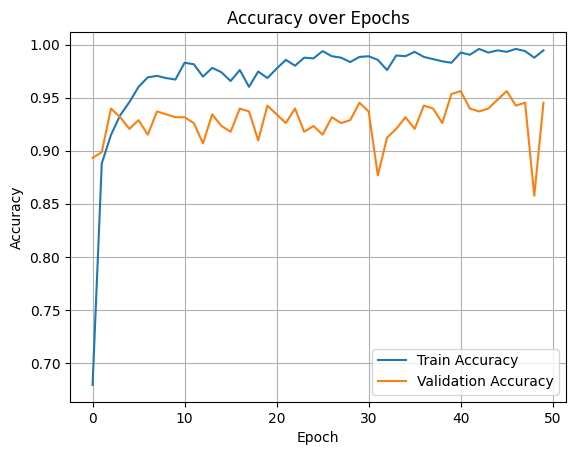

In [60]:
import matplotlib.pyplot as plt

# Ví dụ: plot Loss
plt.plot(train_metrics["loss"], label='Train Loss')
plt.plot(val_metrics["loss"], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Tương tự cho accuracy, F1, recall, v.v.
# Vẽ Accuracy
plt.plot(train_metrics["acc"], label='Train Accuracy')
plt.plot(val_metrics["acc"], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [61]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, accuracy_score
from torch.nn.functional import softmax
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Xử lý nhãn
df['label'] = df[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)
label_encoder = LabelEncoder()
df['label_idx'] = label_encoder.fit_transform(df['label'])

# Chia dữ liệu thành train, val, test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Tạo dataset và dataloader cho tập kiểm tra
test_dataset = AppleDataset(test_df, image_dir, train_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
criterion = nn.CrossEntropyLoss()
all_preds = []
all_labels = []
all_probs = []
total_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)

        # Lấy xác suất và nhãn dự đoán
        probs = softmax(outputs, dim=1).cpu().numpy()  # Xác suất cho tất cả lớp
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # Nhãn dự đoán
        labels = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)
        all_probs.extend(probs)

# Chuyển sang numpy array
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Tính các chỉ số
loss = total_loss / len(test_dataset)  # Mất mát trung bình
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
kappa = cohen_kappa_score(all_labels, all_preds)

# AUC cho bài toán đa lớp (one-vs-rest)
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')

# In kết quả
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Kappa Score: {kappa:.4f}")

Loss: 0.1446
Accuracy: 0.9635
Precision: 0.9608
Recall: 0.9635
F1 Score: 0.9615
AUC: 0.9964
Kappa Score: 0.9471
